# Deep convolutional networks for image classification

Based on [Stanford CS231n](http://cs231n.stanford.edu/syllabus.html) course. The dataset can be loaded from [here](http://www.cs.toronto.edu/~kriz/cifar.html) (make sure you load the python version)

## Reading CIFAR10 dataset

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


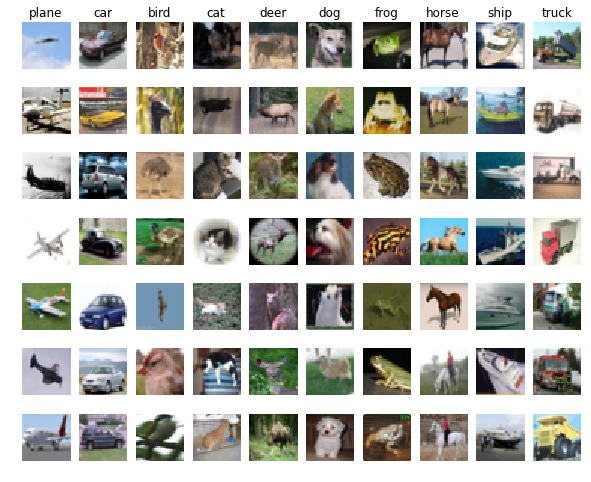

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# KNN classifier

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test  = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape,X_test.shape

(5000L, 3072L) (500L, 3072L)


In [6]:
from cs231n.classifiers import KNearestNeighbor


# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_no_loops.
#   A vectorized implementation that is faster by a factor
#   of 20 than the naive two-loops implementation and factor
#   10 by the slightly more efficient one-loop
#   ( see file k_nearest_neighbor.py)
dists = classifier.compute_distances_no_loops(X_test)

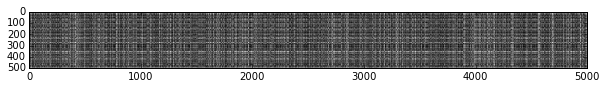

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
k_choices = [1, 3, 5, 7, 8, 10, 12, 15, 20, 50, 100]

for k in k_choices:
    y_test_pred = classifier.predict_labels(dists, k)

    # Compute and print the fraction of correctly predicted examples
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print 'k=%d : Got %d / %d correct => accuracy: %f' % (k,num_correct, num_test, accuracy)

k=1 : Got 137 / 500 correct => accuracy: 0.274000
k=3 : Got 139 / 500 correct => accuracy: 0.278000
k=5 : Got 142 / 500 correct => accuracy: 0.284000
k=7 : Got 141 / 500 correct => accuracy: 0.282000
k=8 : Got 138 / 500 correct => accuracy: 0.276000
k=10 : Got 139 / 500 correct => accuracy: 0.278000
k=12 : Got 130 / 500 correct => accuracy: 0.260000
k=15 : Got 135 / 500 correct => accuracy: 0.270000
k=20 : Got 135 / 500 correct => accuracy: 0.270000
k=50 : Got 126 / 500 correct => accuracy: 0.252000
k=100 : Got 111 / 500 correct => accuracy: 0.222000


# [Linear classification](http://cs231n.github.io/linear-classify/)

** Resources **:[web demo](http://vision.stanford.edu/teaching/cs231n/linear-classify-demo/), [slides](http://vision.stanford.edu/teaching/cs231n/slides/lecture3.pdf). The material below is based on the [notes](http://cs231n.github.io/linear-classify/).

## Scoring function - linear
> $ f(x_i,W,b) = Wx_i + b $

where $y_i \in 1,\cdots,k$ is the label of the $i$'th data point (total of $k$ labels) , $x_i \in \mathcal{R}^D, \quad i = 1,\cdots , N \quad , D=32 \times 32 \times 3 =3072$,  $W$ is an $ k \times N$ matrix and $b \in \mathcal{R}^k$. We want to select $W$ and $b$ so that 

> $ f(x_i,W,b) \approx y_i \quad, i = 1,\cdots, N $

Each row of $W$ along with the corresponding **bias** term of $b$ constitue a single classifier. Some interpretations of  $W$:
* Geometrical interpretation: Each row is a separate linear classifier for one of the classes. It separates the plane into the **in-class** part for which the value is positive and the **out-of-class** part for which the value is negative.
* Template interpretation: A row of $W$ correspond to a **template** (or **prototype**) for one of the classes. The score of each class is obtained by comparing each template with the image using an inner product and seelct the one tha "best fit"
* Examplar interpretation: The weights constitute of one image, aggregated from the train set. The distance between a tst image and this image prototypeis computed via the (negative) inner product.

In practice we add the bias vector as a c(last) olumn of the matrix $W$ and expand the vector $\mathbf{x}$ by adding a last term consisting of the constant one. So we write

> $f(\mathbf{x},W) = W \mathbf{x}$

## Loss functions
In many occasions we will freely name the classifier after our loss function so we will talk about SVM or Softmax classifier instead of about a linear classifier with the hinge loss function of with the cross entropy loss function.

### SVM loss function - the hinge loss

The multiclass SVM loss for the $i$'th example is

> $L_i = \sum_{j \ne y_i} \max( 0, f(x_i,W)_j - f(x_i,W)_{y_i} + \Delta )$

That is we compare the score of $f(x_i,W)$ for the $j$'th class to the score of $f(x_i,W)$ for the class with label $y_i$ (which is the label of the $i$'th example). If that score is larger by a margin $\Delta$ from the score corresponding to the true label, that a positive contrubution is added to the loss function. Otherwise there is no contribution to the loss function.

#### The complete loss function with refularization

> $L = \frac{1}{N } \sum_i L_i + \lambda \sum_k \sum_l W_{k,l}^2 = \frac{1}{N } \sum_i L_i + \lambda R(W)$

Please consider [Andrew's Ng notes (pdf)](http://cs229.stanford.edu/notes/cs229-notes3.pdf) for more information about SVM and its **max-margin** properties.

**Practical considerations**

* It is common to set $\Delta = 0.1$ and to select $\lambda$ by cross validation. This is because in fact these two quantities are related.
* The above formulation is one of the possible extensions of binary SVM to the multi-class setting. It follows the suggestion in [Watson's and Watkins paper (pdf)](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es1999-461.pdf). It is also common to use and One-Vs-All classifier by which we train a binary classifier for each class, see [Rikin et al (pdf)](http://www.jmlr.org/papers/volume5/rifkin04a/rifkin04a.pdf)



### Softmax loss function 
The softmax classifier is an extention of logistic regression classifier for multi-class problems. It is based on the **cross-entropy** loss:

> $L_i = -\log(\frac{e^{f_{y_i}}}{\sum_{j} e^{f_j}}) = -f_{y_i} + \log({\sum_{j} e^{f_j}}) \quad, \quad f_j = f(\mathbf{x_i},W)_j$

The term $\frac{e^{f_{y_i}}}{\sum_{j} e^{f_j}}$ (the softmax function) transform the unormalized quantities $f(\mathbf{x_i},W)_j$ into a number in $[0,1]$ which now can be interpreted as probablity. Minimizing the loss function

> $L = \frac{1}{N } \sum_i L_i + \lambda R(W)$

can be interpreted from two point of views:
* **Information theory view** the softmax classifier minimizes the cross-entrpy which defined between two distributions $p$ and $q$: 
  > $H(p,q) = -\sum_x p(x) \log q(x)$
 
 In the above we take $q$ to be $\frac{e^{f_{y_i}}}{\sum_{j} e^{f_j}}$ and $p$ is the delta distribution $(0,0,\cdots,1,0,\cdots)$ having 0 in all places except the place $y_i$ of the true label of exanple $i$ for which the value is 1. It turns out that this is equivalent to minimizing the Kullback-Leibler divergence which is a measure of the distance between $q$ and $p$ so we woudl like the weight to be such that the prediction will have all the mass in the location of the correct label.
* **Probabilistic view**. We interpret $\frac{e^{f_{y_i}}}{\sum_{j} e^{f_j}}$ as $P(y_i \mid \mathbf{x_i};W)$, the probbality for the (true) label $y_i$ given the data $\mathbf{x_i}$ and the weights $W$. The softmax classifier can then be viewed as maximum-likelihood estimation. In this setting minimizing with the $L2$ regularization can be interpreted as doing a Maximum a posteriori (MAP) estimation.

## Which loss function to use
Most work is done with the softmax function but [some claim](http://arxiv.org/abs/1306.0239) that it is better to use SVM.

# SVM & softmax lab

## Preparing the data for further processing

Train data shape:  (3073L, 49000L)
Train labels shape:  (49000L,)
Validation data shape:  (3073L, 1000L)
Validation labels shape:  (1000L,)
Test data shape:  (3073L, 1000L)
Test labels shape:  (1000L,)


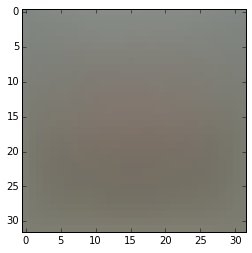

In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
    
  # Display the mean image
  plt.figure(figsize=(4,4))
  plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
  
  return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

# SVM 

In [11]:
# Note: Vectorized form is x8 faster for loss computation
#       and x3 faster for loss and gradient computation
#
# Gradient checking is important as it is very easy to make an
# error in the gradient computation
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.

from cs231n.classifiers.linear_svm import svm_loss_naive
from cs231n.classifiers.linear_svm import svm_loss_vectorized
import time

W = np.random.randn(10, 3073) * 0.0001 
loss, grad = svm_loss_vectorized(W, X_train, y_train, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -41.966026 analytic: -41.967356, relative error: 1.584778e-05
numerical: -2.999554 analytic: -2.999040, relative error: 8.560825e-05
numerical: 11.652197 analytic: 11.652438, relative error: 1.031347e-05
numerical: 0.215979 analytic: 0.216515, relative error: 1.239701e-03
numerical: 41.681794 analytic: 41.678802, relative error: 3.589346e-05
numerical: -4.398156 analytic: -4.399319, relative error: 1.321957e-04
numerical: -0.701273 analytic: -0.699644, relative error: 1.162715e-03
numerical: 20.234061 analytic: 20.235025, relative error: 2.381633e-05
numerical: 32.696511 analytic: 32.696448, relative error: 9.522659e-07
numerical: 15.678631 analytic: 15.678177, relative error: 1.448703e-05


## Mini-batch gradient descent to estimate coefficients

iteration 0 / 1500: loss 782.287907
iteration 100 / 1500: loss 285.654995
iteration 200 / 1500: loss 107.427728
iteration 300 / 1500: loss 41.989175
iteration 400 / 1500: loss 18.332632
iteration 500 / 1500: loss 9.907000
iteration 600 / 1500: loss 6.645195
iteration 700 / 1500: loss 6.008738
iteration 800 / 1500: loss 5.643678
iteration 900 / 1500: loss 5.178851
iteration 1000 / 1500: loss 5.423622
iteration 1100 / 1500: loss 5.014902
iteration 1200 / 1500: loss 5.145385
iteration 1300 / 1500: loss 5.356310
iteration 1400 / 1500: loss 5.394698
That took 14.012000s
training accuracy: 0.365265
validation accuracy: 0.382000


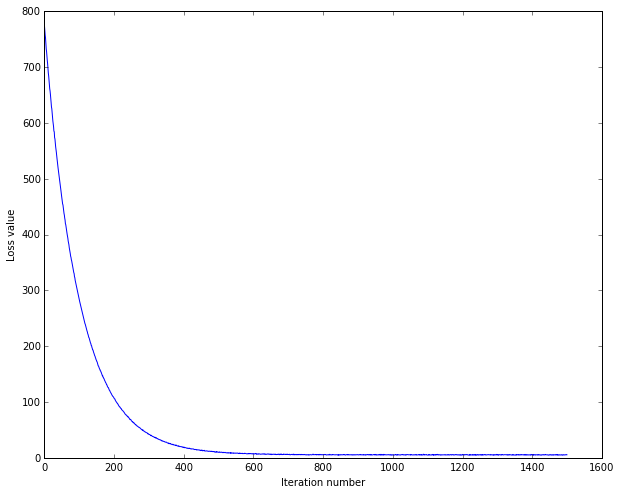

In [12]:
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

# It is advidable to select learning rate, regulariation value
# and control more precisely the stopping criteria
#    learning_rates = [1e-7, 5e-5]
#    regularization_strengths = [5e4, 1e5]

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

# Eevaluate the performance on both the training and validation accuracy
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

# Plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

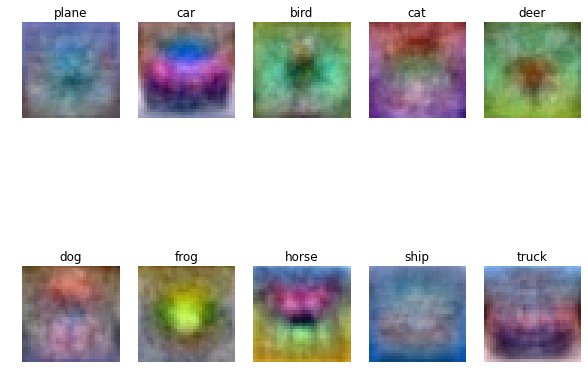

In [13]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

# Softmax

In [14]:
# Vectorized implementation is x10 faster than naive
from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_vectorized

loss, grad = softmax_loss_vectorized(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.770016 analytic: 0.770016, relative error: 2.316688e-08
numerical: 0.741091 analytic: 0.741091, relative error: 5.358478e-08
numerical: -0.301994 analytic: -0.301994, relative error: 1.041172e-07
numerical: 0.948286 analytic: 0.948286, relative error: 1.590021e-08
numerical: 3.189641 analytic: 3.189640, relative error: 1.445677e-08
numerical: 0.815083 analytic: 0.815083, relative error: 4.089990e-08
numerical: 1.507465 analytic: 1.507465, relative error: 1.057603e-08
numerical: 1.055463 analytic: 1.055463, relative error: 2.367647e-08
numerical: 1.617705 analytic: 1.617704, relative error: 8.471249e-09
numerical: -2.560161 analytic: -2.560161, relative error: 5.317097e-09


iteration 0 / 1500: loss 161.626491
iteration 100 / 1500: loss 72.416035
iteration 200 / 1500: loss 33.182915
iteration 300 / 1500: loss 15.837398
iteration 400 / 1500: loss 8.161387
iteration 500 / 1500: loss 4.712554
iteration 600 / 1500: loss 3.240857
iteration 700 / 1500: loss 2.477482
iteration 800 / 1500: loss 2.233768
iteration 900 / 1500: loss 2.199053
iteration 1000 / 1500: loss 1.930433
iteration 1100 / 1500: loss 1.899749
iteration 1200 / 1500: loss 1.923865
iteration 1300 / 1500: loss 1.912681
iteration 1400 / 1500: loss 1.936290
That took 12.087000s
training accuracy: 0.374327
validation accuracy: 0.387000


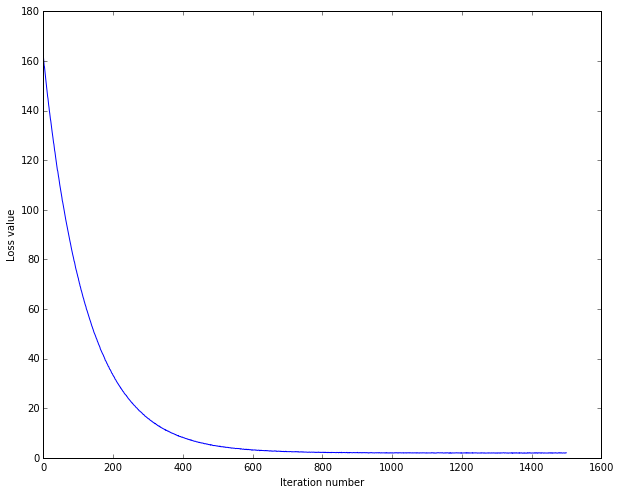

In [15]:
from cs231n.classifiers import Softmax
softm = Softmax()
tic = time.time()

# It is advidable to select learning rate, regulariation value
# and control more precisely the stopping criteria
#   learning_rates = [1e-7, 5e-7]
#   regularization_strengths = [5e4, 1e8]

loss_hist = softm.train(X_train, y_train, learning_rate=4e-7, reg=1e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

# Eevaluate the performance on both the training and validation accuracy
y_train_pred = softm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = softm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

# Plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

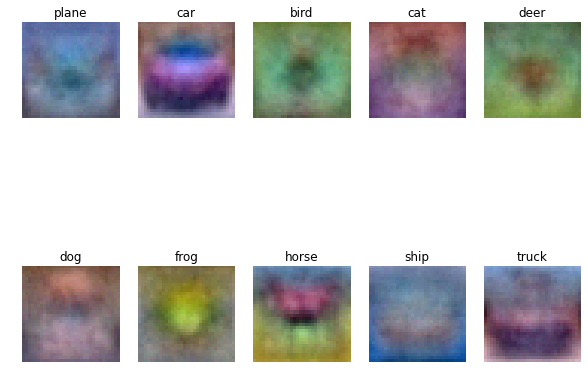

In [16]:
# Visualize the learned weights for each class
w = softm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

# Features

It is rare that image recognition is done on raw pixels. Usually we extract features from the image and do our classification on thise features. See [the slides in here](http://vision.stanford.edu/teaching/cs231n/slides/lecture4.pdf)

In [17]:
# Load the CIFAR10 data
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data1(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data1()

print X_train.shape
print y_train.shape

(49000L, 32L, 32L, 3L)
(49000L,)


In [18]:
from cs231n.features import *

# Extract features. For each image we will compute a Histogram of Oriented
# Gradients (HOG) as well as a color histogram using the hue channel in HSV
# color space. We form our final feature vector for each image by concatenating
# the HOG and color histogram feature vectors.
#
# Roughly speaking, HOG should capture the texture of the image while ignoring
# color information, and the color histogram represents the color of the input
# image while ignoring texture. As a result, we expect that using both together
# ought to work better than using either alone. Verifying this assumption would
# be a good thing to try for the bonus section.

# The hog_feature and color_histogram_hsv functions both operate on a single
# image and return a feature vector for that image. The extract_features
# function takes a set of images and a list of feature functions and evaluates
# each feature function on each image, storing the results in a matrix where
# each column is the concatenation of all feature vectors for a single image.

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=1)
mean_feat = np.expand_dims(mean_feat, axis=1)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=1)
std_feat = np.expand_dims(std_feat, axis=1)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.vstack([X_train_feats, np.ones((1, X_train_feats.shape[1]))])
X_val_feats = np.vstack([X_val_feats, np.ones((1, X_val_feats.shape[1]))])
X_test_feats = np.vstack([X_test_feats, np.ones((1, X_test_feats.shape[1]))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

### svm classification on selected features

iteration 0 / 1500: loss 728.709210
iteration 100 / 1500: loss 9.025201
iteration 200 / 1500: loss 8.999965
iteration 300 / 1500: loss 8.999968
iteration 400 / 1500: loss 8.999965
iteration 500 / 1500: loss 8.999963
iteration 600 / 1500: loss 8.999968
iteration 700 / 1500: loss 8.999973
iteration 800 / 1500: loss 8.999968
iteration 900 / 1500: loss 8.999967
iteration 1000 / 1500: loss 8.999978
iteration 1100 / 1500: loss 8.999969
iteration 1200 / 1500: loss 8.999961
iteration 1300 / 1500: loss 8.999961
iteration 1400 / 1500: loss 8.999956
That took 8.660000s
training accuracy: 0.417000
validation accuracy: 0.416000


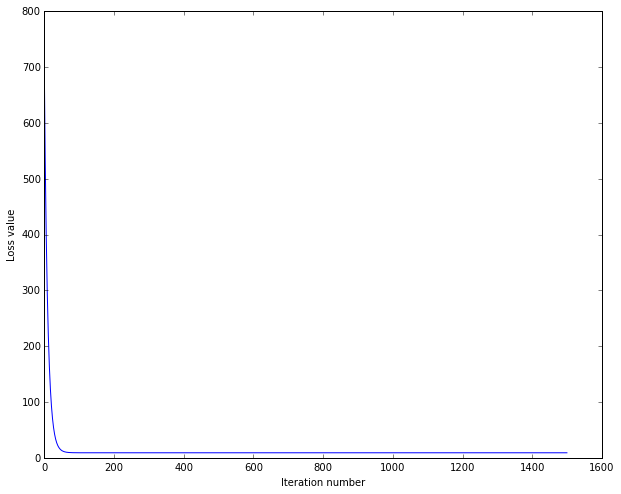

In [19]:
from cs231n.classifiers import LinearSVM
svm_f = LinearSVM()
tic   = time.time()

loss_hist = svm_f.train(X_train_feats, y_train, learning_rate=5e-8, reg=1e6,
                        num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

# Eevaluate the performance on both the training and validation accuracy
y_train_pred = svm_f.predict(X_train_feats)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm_f.predict(X_val_feats)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

# Plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [20]:
# Evaluate your classifier on the test set
y_test_pred = svm_f.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.417


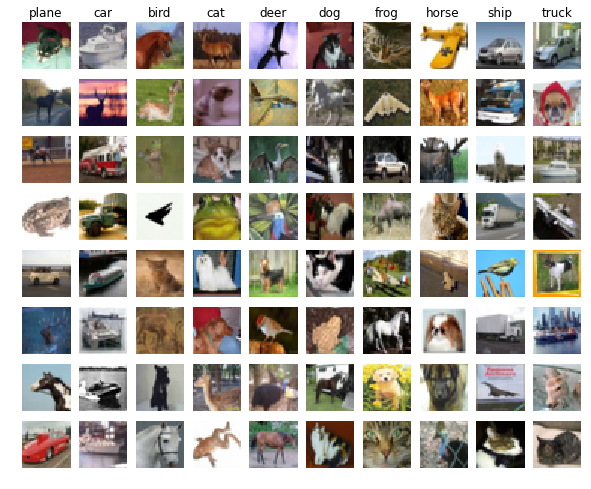

In [21]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

iteration 0 / 1000: loss 1639.780085
iteration 100 / 1000: loss 2.302586
iteration 200 / 1000: loss 2.302585
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302585
iteration 500 / 1000: loss 2.302585
iteration 600 / 1000: loss 2.302585
iteration 700 / 1000: loss 2.302585
iteration 800 / 1000: loss 2.302585
iteration 900 / 1000: loss 2.302585
That took 4.918000s
training accuracy: 0.422224
validation accuracy: 0.419000


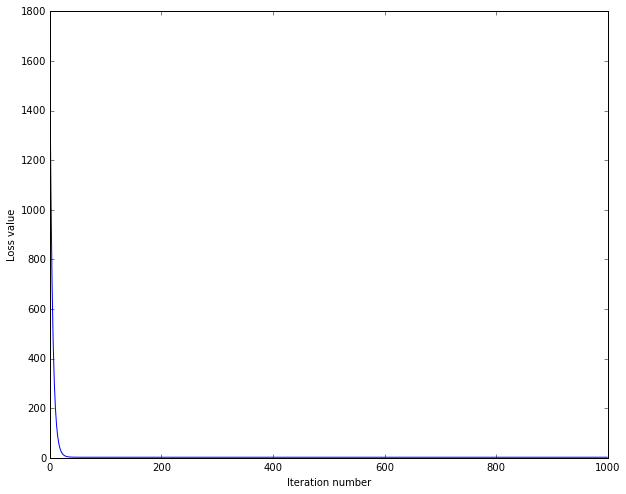

In [22]:
from cs231n.classifiers import Softmax
soft_f = Softmax()
tic    = time.time()

loss_hist = soft_f.train(X_train_feats, y_train, 
                         learning_rate=5e-8, reg=2e6,
                         num_iters=1000, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

# Eevaluate the performance on both the training and validation accuracy
y_train_pred = soft_f.predict(X_train_feats)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = soft_f.predict(X_val_feats)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

# Plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [23]:
# Evaluate your classifier on the test set
y_test_pred = soft_f.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.418


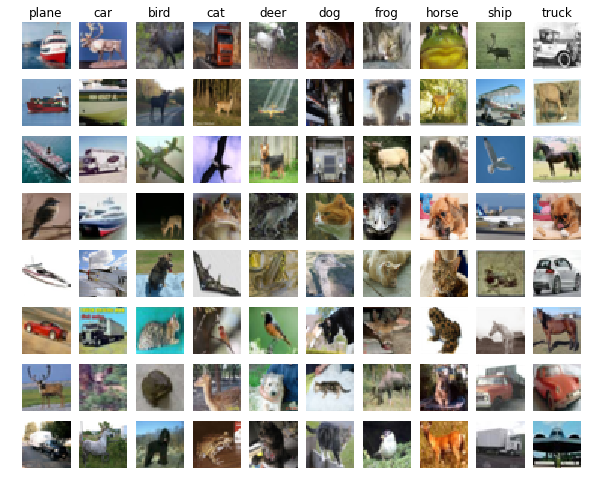

In [274]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [54]:
A = np.array([[1,2,3,4],[5,6,7,8]])
b = np.array([1,1,1,1])
c = np.array([[1],[2]])
print c.shape

print A
print np.sum(A**2,axis=0) # Sum columns
print np.sum(A**2,axis=1) # sum rows
print
print A-b
print A - c
print np.linalg.norm(A - b,axis=1)

(2L, 1L)
[[1 2 3 4]
 [5 6 7 8]]
[26 40 58 80]
[ 30 174]

[[0 1 2 3]
 [4 5 6 7]]
[[0 1 2 3]
 [3 4 5 6]]
[  3.74165739  11.22497216]
